<a href="https://colab.research.google.com/github/AnniMV/JODA2021/blob/main/Harjoitustyo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Johdanto datatieteeseen - Harjoitustyö

Johdanto datatieteeseen -harjoitustyössä käydään läpi datatiedeprojektin keskeiset vaiheet. Tässä harjoitustyössä käytetään Bondoran lainadatasettiä, josta tehdään analyysi kuvailemalla vaiheita datan jalostamisesta raporttiin.

## Kehitysympäristö
Kehitysympäristönä toimii Googlen Colab notebook.

Colabin käytön voi aloittaa kirjautumalla Google-tunnuksilla osoitteessa https://colab.research.google.com. Työkirjat tallentuvat Google Drive pilvipalveluun, ja omia tiedostoja voi myös käyttää tätä kautta.

##Datan kerääminen
Analyysissä käytetään Bondoran tarjoamaa Loan datasettiä, joka on ladattavissa osoitteesta https://www.bondora.com/en/public-reports, "Loan dataset". Se tarjoaa ajantasaisen ja laajan datasetin lainadatasta. Sivusto sisältää myöskin datan kuvailun, mistä nähdään kunkin muuttujan kuvaus.

Ladatun datan voi tallentaa esimerkiksi omaan Google Driveen ja lukea sen sieltä seuraavasti, (muuta oma hakemisto):

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/LoanData.csv')
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (34,38,80,82,83,89,90) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ReportAsOfEOD,LoanId,LoanNumber,ListedOnUTC,BiddingStartedOn,BidsPortfolioManager,BidsApi,BidsManual,UserName,NewCreditCustomer,LoanApplicationStartedDate,LoanDate,ContractEndDate,FirstPaymentDate,MaturityDate_Original,MaturityDate_Last,ApplicationSignedHour,ApplicationSignedWeekday,VerificationType,LanguageCode,Age,DateOfBirth,Gender,Country,AppliedAmount,Amount,Interest,LoanDuration,MonthlyPayment,County,City,UseOfLoan,Education,MaritalStatus,NrOfDependants,EmploymentStatus,EmploymentDurationCurrentEmployer,EmploymentPosition,WorkExperience,OccupationArea,...,EAD2,PrincipalRecovery,InterestRecovery,RecoveryStage,StageActiveSince,ModelVersion,Rating,EL_V0,Rating_V0,EL_V1,Rating_V1,Rating_V2,Status,Restructured,ActiveLateCategory,WorseLateCategory,CreditScoreEsMicroL,CreditScoreEsEquifaxRisk,CreditScoreFiAsiakasTietoRiskGrade,CreditScoreEeMini,PrincipalPaymentsMade,InterestAndPenaltyPaymentsMade,PrincipalWriteOffs,InterestAndPenaltyWriteOffs,PrincipalBalance,InterestAndPenaltyBalance,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousRepaymentsBeforeLoan,PreviousEarlyRepaymentsBefoleLoan,PreviousEarlyRepaymentsCountBeforeLoan,GracePeriodStart,GracePeriodEnd,NextPaymentDate,NextPaymentNr,NrOfScheduledPayments,ReScheduledOn,PrincipalDebtServicingCost,InterestAndPenaltyDebtServicingCost,ActiveLateLastPaymentCategory
0,2021-04-21,66AE108B-532B-4BB3-BAB7-0019A46412C1,483449,2016-03-23 16:07:19,2016-03-23 16:07:19,970.0,1150.0,5.0,BO965519,False,2016-03-17 12:39:22,2016-03-23,2020-06-26,2016-05-12,2021-04-12,2020-06-26,17,4,4.0,1,53,NaN,1.0,EE,2125.0,2125.0,20.97,60,62.05,NaN,NaN,2,4.0,2.0,0,6.0,MoreThan5Years,NaN,15To25Years,1.0,...,64.07,85.96,0.0,2.0,2020-03-03 09:27:48.493000000,2.0,C,NaN,NaN,NaN,NaN,C,Late,False,180+,180+,NaN,NaN,NaN,1000.0,958.98,1187.91,0.00,0.00,1166.02,378.30,1,500.0,590.95,0.0,0,2019-10-28,2020-01-27,NaN,NaN,NaN,NaN,0.00,46.24,8-15
1,2021-04-21,D152382E-A50D-46ED-8FF2-0053E0C86A70,378148,2015-06-25 11:02:28,2015-06-25 11:02:28,1295.0,0.0,1705.0,BOA9K172A,False,2015-06-24 12:36:16,2015-06-25,NaN,2015-08-17,2020-07-17,2020-07-17,11,5,1.0,1,50,NaN,1.0,EE,3000.0,3000.0,17.12,60,84.75,NaN,NaN,3,5.0,2.0,0,5.0,MoreThan5Years,NaN,MoreThan25Years,7.0,...,2370.77,294.43,0.0,2.0,2019-08-01 14:18:33,1.0,B,NaN,NaN,0.030799,B,B,Late,False,180+,180+,NaN,NaN,NaN,1000.0,563.59,360.07,0.00,0.00,2436.41,2187.55,1,1800.0,445.26,3000.0,1,NaN,NaN,NaN,NaN,NaN,NaN,0.00,47.08,180+
2,2021-04-21,87342E13-66CB-483F-833A-007953E50C78,451831,2016-01-14 10:00:21,2016-01-14 10:00:21,2700.0,565.0,5835.0,BO7971663,True,2016-01-07 15:37:16,2016-01-19,2019-10-24,2016-02-22,2021-01-20,2021-01-20,22,3,4.0,1,44,NaN,0.0,EE,10630.0,9100.0,13.67,60,268.57,NaN,NaN,3,4.0,4.0,1,5.0,UpTo3Years,NaN,MoreThan25Years,8.0,...,5014.54,4160.01,0.0,2.0,2018-02-28 14:43:37.670000000,2.0,A,NaN,NaN,NaN,NaN,A,Repaid,False,180+,180+,NaN,NaN,NaN,1000.0,6537.00,1708.47,2303.33,0.88,0.00,0.00,0,0.0,0.00,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,259.67,1659.60,180+
3,2021-04-21,87227056-6BF9-410C-98D1-008F788E122A,349381,2015-03-24 15:55:44,2015-03-24 15:55:44,1115.0,0.0,385.0,BO76151K3,True,2015-03-20 15:20:48,2015-03-27,NaN,2015-05-04,2020-04-01,2020-04-01,15,3,3.0,6,42,NaN,0.0,ES,1500.0,1500.0,40.40,60,63.53,NaN,NaN,2,2.0,1.0,0,3.0,UpTo5Years,NaN,5To10Years,1.0,...,1078.76,399.41,0.0,1.0,2020-11-27 00:00:00,1.0,F,NaN,NaN,0.220810,F,HR,Late,False,180+,180+,M3,B,NaN,NaN,464.73,355.92,0.00,0.00,1035.27,2729.27,0,0.0,0.00,1500.0,1,NaN,NaN,NaN,NaN,NaN,NaN,0.00,215.05,180+
4,2021-04-21,2DDE6336-E466-4624-A337-00A0ED1A1468,443082,2015-12-17 10:12:00,2015-12-17 10:12:00,305.0,0.0,785.0,BOK423A63,True,2015-12-13 00:30:08,2015-12-22,NaN,2016-02-01,2020-01-02,2020-01-02,20,3,4.0,6,34,NaN,1.0,ES,1595.0,1090.0,68.39,48,101.19,NaN,NaN,7,4.0,4.0,2,6.0,UpTo1Year,NaN,5To10Years,1.0,...,1089.99,0.00,0.0,1.0,2020-11-27 00:00:00,2.0,HR,NaN,NaN,NaN,NaN,HR,Late,False,180+,180+,M5,C,NaN,NaN,0.01,0.00,0.00,0.00,1089.99,4029.01,0,0.0,0.00,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,180+


TAI pudottaa tiedosto samaan työkirjaistuntoon ja lukea seuraavasti:

In [ ]:
df=pd.read_csv('LoanData.csv')
df.head()

##Datan jalostaminen
Bondoran lainadata sisältää 112 saraketta, jotka edustavat erilaisia tietoja lainasta ja lainan ottajasta. Valmis data on varsin siistissä muodossa, mutta dataa on silti siistittävä ja karsittava omiin käyttötarkoituksiin sopivaksi. Tutkittavia aiheita ovat esimerkiksi maksukyvyttömyys, mitkä asiat vaikuttavat lainanmaksuun ja millainen taloudellinen tilanne lainanottajalla on. Nämä kysymykset mielessä valitaan datasta sellaiset sarakkeet jotka mahdollisesti kuvaavat näitä aiheita, ja rajataan data koskemaan Suomessa asuvia lainanottajia. Valitaan sellaiset lainat, joissa sopimus on jo päättynyt jotta voidaan tarkastella lainan koko elinkaarta.



In [4]:
data = df.loc[:,['NewCreditCustomer','Age','Gender','Country', 
                 'Amount','LoanDuration','MonthlyPayment',
                 'Education','NrOfDependants','EmploymentStatus',
                 'EmploymentDurationCurrentEmployer',
                 'PrincipalBalance',
                 'NoOfPreviousLoansBeforeLoan','AmountOfPreviousLoansBeforeLoan',
                 'ExistingLiabilities',
                 'IncomeTotal',
                 'ProbabilityOfDefault',
                 'DefaultDate','LoanDate','ContractEndDate']]

In [5]:
# muutetaan tietotyyppejä
data['LoanDate'] = pd.to_datetime(data['LoanDate'])
data['ContractEndDate'] = pd.to_datetime(data['ContractEndDate'])

data = data.dropna(subset=['ContractEndDate'])

data = data[data['ContractEndDate'] < '2021-04-01']

data = data[data.Country == 'FI']


In [6]:
data.head(6)

,NewCreditCustomer,Age,Gender,Country,Amount,LoanDuration,MonthlyPayment,Education,NrOfDependants,EmploymentStatus,EmploymentDurationCurrentEmployer,PrincipalBalance,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,ExistingLiabilities,IncomeTotal,ProbabilityOfDefault,DefaultDate,LoanDate,ContractEndDate
8,True,60,0.0,FI,4000.0,36,185.35,4.0,0,3.0,MoreThan5Years,0.0,0,0.0,8,2590.0,0.125412,2016-09-06,2015-03-13,2016-09-14
18,True,67,0.0,FI,3720.0,60,121.52,3.0,0,6.0,UpTo2Years,0.0,0,0.0,12,1391.0,0.198666,NaN,2016-01-14,2016-09-05
33,True,68,0.0,FI,1000.0,60,34.33,2.0,0,6.0,MoreThan5Years,0.0,0,0.0,8,1706.0,0.117360,NaN,2015-09-21,2020-08-09
36,False,43,0.0,FI,4785.0,60,159.30,5.0,0,3.0,MoreThan5Years,0.0,2,4635.0,6,1871.0,0.107243,NaN,2015-11-16,2021-03-02
49,True,26,0.0,FI,3590.0,60,305.50,3.0,1,3.0,UpTo5Years,0.0,0,0.0,2,1648.0,0.068327,NaN,2015-07-29,2015-08-05
54,True,44,0.0,FI,2655.0,60,99.25,4.0,1,3.0,UpTo5Years,0.0,0,0.0,15,2127.0,0.293649,NaN,2016-02-16,2016-11-16


DefaultDate: Päivämäärä jolloin laina on mennyt maksukyvyttömyystilaan ja perintä on aloitettu.

Annetaan maksukyvyttömyystilaan menneille lainoille arvo 1 ja muille 0.

In [7]:
data.DefaultDate = (data.DefaultDate.notnull()).astype('int')

data = data.rename(columns={'DefaultDate': 'DefaultState'})
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9483 entries, 8 to 166925
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   NewCreditCustomer                  9483 non-null   bool          
 1   Age                                9483 non-null   int64         
 2   Gender                             9483 non-null   float64       
 3   Country                            9483 non-null   object        
 4   Amount                             9483 non-null   float64       
 5   LoanDuration                       9483 non-null   int64         
 6   MonthlyPayment                     9164 non-null   float64       
 7   Education                          9483 non-null   float64       
 8   NrOfDependants                     2668 non-null   object        
 9   EmploymentStatus                   9483 non-null   float64       
 10  EmploymentDurationCurrentEmployer 

In [ ]:
data.head(6)

Lisätään dataan uusi sarake, jotta voidaan vertailla lainan takaisinmaksukestoa myönnettyyn laina-ajan kestoon. Lainalle on myönnetty tietty aika, mutta esimerkiksi maksukyvyttömyys ja maksamatta jättäminen siirtävät erääntymispäivää. Samoin laina-aika lyhenee jos sen maksaa takaisin aikaisemmin.

In [8]:
data['LoanDurationLast'] = ""


for x in range(len(data['ContractEndDate'])):
    difference = pd.Timedelta(data['ContractEndDate'].values[x]-data['LoanDate'].values[x]).days
    
    data['LoanDurationLast'].values[x] = difference


In [9]:
#muutetaan päivät vielä karkeasti kuukausiksi
data['LoanDurationLast'] = data['LoanDurationLast']/365*12

data['LoanDurationLast'] = data['LoanDurationLast'].astype(float)

data['LoanDurationLast'] = data['LoanDurationLast'].round()

data.LoanDurationLast = data.LoanDurationLast.astype(int)


Käytetään imputointimenetelmää muuttujan 'NrOfDependants' tyhjien arvojen korvaamiseen. Muuttuja kertoo kuinka monta huollettavaa lainan hakijalla on. Korvataan tyhjät arvot nyt vakiolla 0 sillä oletuksella että jos lainanhakijalla ei ole huollettavia, hän ei ole niin kiinnostunut kysymyksestä ja jättää vastauksen tyhjäksi. Samalla muutetaan kaikki arvot kokonaisluvuiksi.

Tehdään sama myös muuttujalle 'ProbabilityOfDefault', joka kertoo todennäköisyyden maksukyvyttömyyteen vuoden sisällä, ja imputoidaan tyhjät arvot keskiarvolla.


In [10]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
data[['NrOfDependants']] = imputer.fit_transform(data[['NrOfDependants']])
data['NrOfDependants'] = data['NrOfDependants'].astype(int)

imputer2 = SimpleImputer()
data[['ProbabilityOfDefault']] = imputer2.fit_transform(data[['ProbabilityOfDefault']])

In [11]:
data.describe()

,Age,Gender,Amount,LoanDuration,MonthlyPayment,Education,NrOfDependants,EmploymentStatus,PrincipalBalance,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,ExistingLiabilities,IncomeTotal,ProbabilityOfDefault,DefaultState,LoanDurationLast
count,9483.000000,9483.000000,9483.000000,9483.000000,9164.000000,9483.000000,9483.000000,9483.000000,9483.000000,9483.000000,9483.000000,9483.000000,9.483000e+03,9483.000000,9483.000000,9483.000000
mean,43.844775,0.373300,3484.530845,48.446694,168.284498,3.553306,0.179374,0.267848,80.268603,0.550459,1709.069005,2.941158,2.815153e+03,0.280457,0.206158,14.322683
std,12.839835,0.483706,2340.401050,14.295625,129.742316,1.170446,0.612040,2.052405,571.884334,1.179547,3635.056561,3.467284,1.545216e+04,0.139681,0.404567,16.027024
min,18.000000,0.000000,176.000000,3.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.200000e+00,0.000000,0.000000,0.000000
25%,34.000000,0.000000,2020.000000,36.000000,90.857500,3.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,1.000000,1.650000e+03,0.150150,0.000000,3.000000
50%,43.000000,0.000000,3070.000000,60.000000,138.340000,3.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,2.000000,2.085000e+03,0.286733,0.000000,9.000000
75%,54.000000,1.000000,4250.000000,60.000000,227.992500,5.000000,0.000000,3.000000,0.000000,1.000000,2125.000000,4.000000,2.647000e+03,0.399250,0.000000,19.000000
max,70.000000,1.000000,10630.000000,60.000000,1871.460000,5.000000,7.000000,6.000000,10567.810000,18.000000,49027.000000,33.000000,1.012019e+06,0.813449,1.000000,91.000000


'EmplymentStatus' saa seuraavia arvoja: 1 Unemployed 2 Partially employed 3 Fully employed 4 Self-employed 5 Entrepreneur 6 Retiree. 

Datassa arvo 1 on kuitenkin muuttunut arvoksi -1 joten korjataan se ja muutetaan kaikki arvot kokonaisluvuiksi.

In [12]:
data.EmploymentStatus = data.EmploymentStatus.abs().astype(int)

##Datan kuvaileminen
Tutkitaan dataa visuaalisesti. Tarkastellaan ensin lainoja lainan alkamispäivän mukaan. Kuluttajaluottojen määräaikainen korkokaton laskeminen 1.7.2020–31.12.2020 korona-aikaan laittoi monet yritykset miettimään uudelleen lainan myöntämiskriteereitä. Seuraavassa kuvassa, jossa on käytetty koko ladattua dataa, näkyy rako suurimmissa myönnetyissä summissa, mutta pienempiä lainoja on edelleen myönnetty.

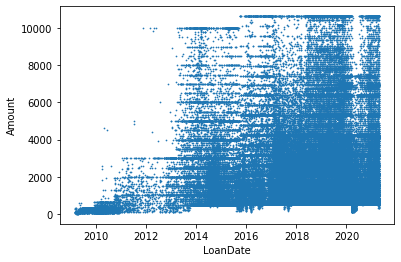

In [13]:
df['LoanDate'] = pd.to_datetime(df['LoanDate'])
df.plot.scatter(x='LoanDate', y='Amount', s=0.5)

Seuraava kuva on jalostetulla datalla, jossa lainojen päättymispäivät ovat ennen 1.4.2021. Kuvasta huomaa, että lyhytkestoisia lainoja ei ole myönnetty silloin kun korkokaton sääntelyä on ehdotettu valmisteltavaksi.

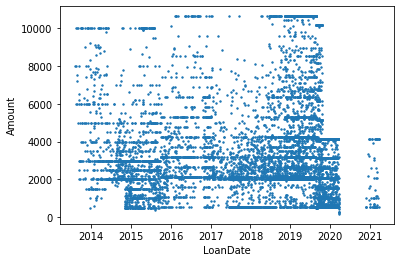

In [14]:
data.plot.scatter(x='LoanDate', y='Amount', s=2)

Tarkastellaan lainanhakijan tulojen ja haetun lainan määrän suhdetta ja määritellään siihen regressiosuora. Huomataan, että tulojen suuruudella ei ole vaikutusta haettavaan lainan suuruuteen. 

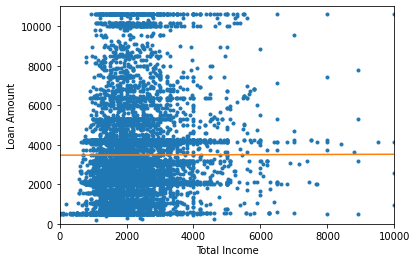

In [15]:
x = data.IncomeTotal
y = data.Amount

m, b = np.polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.xlim(0,10000) 
plt.ylim(0,11000)
xreg = np.linspace(0,10000)
plt.plot(xreg, b + m * xreg, '-')
plt.xlabel('Total Income')
plt.ylabel('Loan Amount')
plt.show()

Lainan takaisinmaksuaika on 3 - 60 kk. Seuraavassa kuvassa tarkastellaan myönnettyä maksuaikaa ('LoanDuration') verrattuna lainan todelliseen kestoon ('LoanDurationLast) eli aikaan lainasopimuksen alkamispäivästä lainan päättymispäivään. Kuvasta huomataan että laina-ajat sekä alittuvat myönnetystä maksuajasta kun laina on maksettu aikaisemmin takaisin, että ylittyvät kun lainan takaisinmaksuja ei ole hoidettu sovitusti.

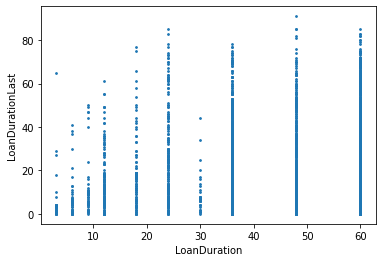

In [16]:
data.plot.scatter(x='LoanDuration', y='LoanDurationLast',s=3)

Tarkastellaan maksukyvyttömyystilaa lainanhakijan työllisyystilanteen mukaan. 'DefaultState on 0 kun takaisinmaksu on hoidettu sovitusti ja 1 kun maksu on laiminlyöty ja perintä on aloitettu. Työllisyystilanne ('EmploymentStatus') on jaoteltu seuraavasti: 1 Unemployed, 2 Partially employed, 3 Fully employed, 4 Self-employed, 5 Entrepreneur, 6 Retiree. 

Lukumäärältään lainanottajia on eniten työttömissä, ja toisena tulee täysin työllistettyjen ryhmä, mutta laiminlyötyjen lainojen suhde takaisin maksettuihin on huomattavasti suurempi tässä ryhmässä kuin työttömien osuudessa.

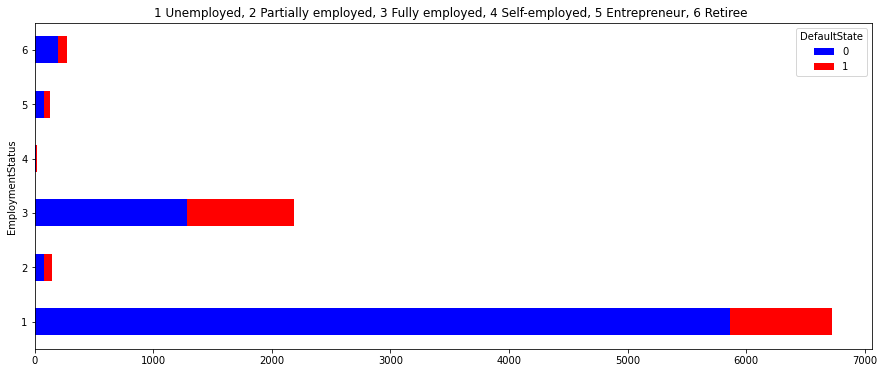

In [17]:
data.groupby(['EmploymentStatus'])['DefaultState'].value_counts()\
.unstack().plot(kind='barh', stacked=True, figsize=(15,6), color=('b', 'r'), 
                title='1 Unemployed, 2 Partially employed, 3 Fully employed, 4 Self-employed, 5 Entrepreneur, 6 Retiree ')


##Koneoppiminen
Yritetään monimuuttujaregressiolla ennustaa lainanottajan ennakkotiedoilla, tuleeko hän maksamaan lainansa takaisin vai meneekö laina maksukyvyttömyystilaan ja perintään.  Siksi selittäviksi muuttujiksi valittiin Bondoran lainadatasetistä sellaisia muuttujia, jotka ovat tiedossa ennen lainan myöntämistä.

Selittävien muuttujien kategoriset arvot muutetaan dummy-muuttujiksi ja selitettävä muuttuja 'DefaultState' saa arvoja 1 tai 0 (maksettu takaisin tai maksun laiminlyönti). Muuttujiksi valittiin seuraavat:

In [18]:
learndata = data.loc[:,['Age','Amount','LoanDuration',
                 'Education','NrOfDependants','EmploymentStatus',
                 'EmploymentDurationCurrentEmployer',
                 'AmountOfPreviousLoansBeforeLoan',
                 'IncomeTotal','DefaultState']]
      

In [19]:
learndata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9483 entries, 8 to 166925
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                9483 non-null   int64  
 1   Amount                             9483 non-null   float64
 2   LoanDuration                       9483 non-null   int64  
 3   Education                          9483 non-null   float64
 4   NrOfDependants                     9483 non-null   int64  
 5   EmploymentStatus                   9483 non-null   int64  
 6   EmploymentDurationCurrentEmployer  9476 non-null   object 
 7   AmountOfPreviousLoansBeforeLoan    9483 non-null   float64
 8   IncomeTotal                        9483 non-null   float64
 9   DefaultState                       9483 non-null   int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 814.9+ KB


In [20]:
#poistetaan rivit joissa on vielä tyhjiä arvoja
learndata=learndata.dropna()

In [21]:
# Muutetaan 'Education', 'NrOfDependants' ja 'EmploymentStatus' object tietotyypiksi
learndata.Education = learndata.Education.astype(object)
learndata.EmploymentStatus = learndata.EmploymentStatus.astype(object)
learndata.NrOfDependants = learndata.NrOfDependants.astype(object)

In [22]:
y = learndata['DefaultState']

learndata = learndata.drop('DefaultState', axis=1)

In [23]:
learndata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9476 entries, 8 to 166925
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                9476 non-null   int64  
 1   Amount                             9476 non-null   float64
 2   LoanDuration                       9476 non-null   int64  
 3   Education                          9476 non-null   object 
 4   NrOfDependants                     9476 non-null   object 
 5   EmploymentStatus                   9476 non-null   object 
 6   EmploymentDurationCurrentEmployer  9476 non-null   object 
 7   AmountOfPreviousLoansBeforeLoan    9476 non-null   float64
 8   IncomeTotal                        9476 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 740.3+ KB


In [24]:
# kategoriset arvot numeerisiksi

X = pd.get_dummies(learndata)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9476 entries, 8 to 166925
Data columns (total 33 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Age                                               9476 non-null   int64  
 1   Amount                                            9476 non-null   float64
 2   LoanDuration                                      9476 non-null   int64  
 3   AmountOfPreviousLoansBeforeLoan                   9476 non-null   float64
 4   IncomeTotal                                       9476 non-null   float64
 5   Education_1.0                                     9476 non-null   uint8  
 6   Education_2.0                                     9476 non-null   uint8  
 7   Education_3.0                                     9476 non-null   uint8  
 8   Education_4.0                                     9476 non-null   uint8  
 9   Education_5.0    

Jaetaan data opetus- ja testidataan. Valitaan joitakin luokittelijoita ja verrataan niiden tarkkuutta:

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
       X, y, test_size=0.33, random_state=31)

Mallinnetaan opetusdata ja arvioidaan tarkkuus.

In [26]:
classifiers = [DecisionTreeClassifier(), SGDClassifier(), LogisticRegression(), SVC()]

for clf in classifiers:
  #mallinnus opetusdatalla
  clf.fit(X=X_train, y=y_train)
        
  #ennusteet testidatalla
  predictions = clf.predict(X=X_test)
        
  #tarkuus
  accuracy = accuracy_score(y_test, predictions)
        
  print("\t Classifier {}: accuracy {}.".format(clf, accuracy))  



	 Classifier DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'): accuracy 0.7209079283887468.
	 Classifier SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False): accuracy 0.7861253196930946.
	 Classifier LogisticRegression(C=1.0, class_weight=None, dual=

Mallin tarkkuudeksi saatiin 0,789 eli vähän vajaa 80 % tapauksista saatiin ennustettua oikein lainanottajan maksukyky. Tarkkuus ei ole niin hyvä että sitä kannattaisi pelkästään käyttää päätöksenteossa.

##Toimeenpano
Analyysista nähtiin, että suurin ryhmä, joille lainoja on myönnetty ovat työttämät ja toiseksi suurin on kokoaikaisessa työssä olevat. Kuitenkin kokoaikaisessa työssä olevilla laiminlyötyjen maksujen osuus kaikista lainoista tässä ryhmässä on suuri, joten pelkkä palkansaanti ei takaa että lainanottaja kykenee maksamaan lainaa takaisin. 

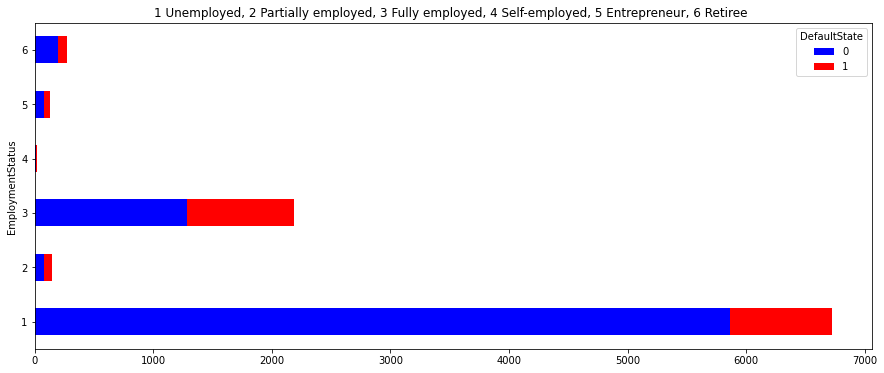

Datasta huomattiin, että myönnetty lainamäärä ei riipu hakijan tulojen suuruudesta, ja lainan maksuajat ylittyvät osassa tapauksissa annetusta maksuajasta poiketen, jolloin myös yrityksen voittojen saaminen vaarantuu. On siis tärkeää tutkia lainanottajan taustoja ja selvittää, kuinka suuren osan tuloistaan lainanottaja pystyy laittamaan lainan takaisinmaksuun. Koneoppimismallia voi käyttää apuna päätöksenteossa, mutta koska malli ei ole kovin tarkka, ei ole järkevää käyttää sitä yksinään.